In [1]:
# =========================================
# Cell 1: Import Libraries
# =========================================
import pandas as pd
import numpy as np

import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# =========================================
# Cell 2: Load Dataset
# =========================================
df = pd.read_csv("../Dataset/url_dataset_combined_1.csv")

# Verify required columns
if not {"url", "label"}.issubset(df.columns):
    raise ValueError("Dataset must contain 'url' and 'label' columns.")

df = df.dropna(subset=["url", "label"])
df["label"] = df["label"].astype(int)

print("Sample rows:"); print(df.head())
print("\nLabel Distribution:"); print(df["label"].value_counts())


Sample rows:
                                               url  label
0  https://keraekken-loagginnusa.godaddysites.com/      1
1         https://metamsk01lgiix.godaddysites.com/      1
2                          http://myglobaltech.in/      1
3                   http://djtool-for-spotify.com/      1
4  https://scearmcoommunnlty.com/invent/freind/get      1

Label Distribution:
label
0    483278
1    239523
Name: count, dtype: int64


In [ ]:
# =========================================
# Cell 3: URL Feature Extractor
# =========================================
class URLFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, urls):
        urls = np.array(urls).reshape(-1)  # ensure 1D
        feats = np.array([
            [
                len(u),
                u.count('-'),
                u.count('@'),
                u.count('?'),
                u.count('='),
                u.count('.'),
                int(u.startswith("https")),
                int(u.count("//") > 1)
            ]
            for u in urls
        ])
        return csr_matrix(feats)  # sparse → faster and memory-efficient


In [ ]:
# =========================================
# Cell 4: Train/Test Split (NO ERRORS)
# =========================================
X = df[["url"]]          # must be DataFrame
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
# =========================================
# Cell 5: Pipeline with Balanced Logistic Regression
# =========================================
pipeline = Pipeline([
    ("features", ColumnTransformer([
        ("tfidf", TfidfVectorizer(max_features=3000), "url"),
        ("url_stats", URLFeatures(), "url")
    ])),
    ("clf", LogisticRegression(
        class_weight="balanced",   # auto dataset balancing
        solver="liblinear",
        max_iter=2000
    ))
])


In [ ]:
# =========================================
# Cell 6: Train Model
# =========================================
pipeline.fit(X_train, y_train)
print("🚀 Model training completed successfully!")


🚀 Model training completed successfully!


In [ ]:
# =========================================
# Cell 7: Evaluate Model
# =========================================
pred = pipeline.predict(X_test)

print("\nModel Performance:")
print(f"Accuracy : {accuracy_score(y_test, pred):.4f}")
print(f"Precision: {precision_score(y_test, pred):.4f}")
print(f"Recall   : {recall_score(y_test, pred):.4f}")
print(f"F1 Score : {f1_score(y_test, pred):.4f}")



Model Performance:
Accuracy : 0.9711
Precision: 0.9473
Recall   : 0.9667
F1 Score : 0.9569


🔍 Confusion Matrix:
[[94077  2579]
 [ 1593 46312]]


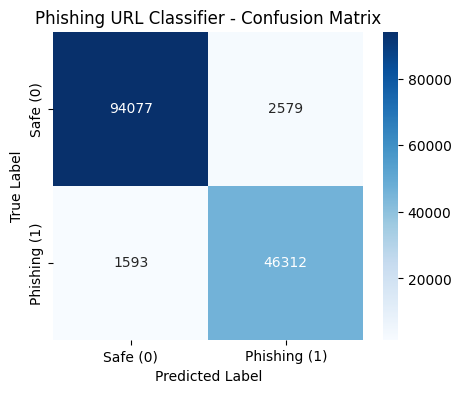


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     96656
           1       0.95      0.97      0.96     47905

    accuracy                           0.97    144561
   macro avg       0.97      0.97      0.97    144561
weighted avg       0.97      0.97      0.97    144561



In [ ]:

# Get predictions on test data
y_pred = pipeline.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display numeric matrix
print("🔍 Confusion Matrix:")
print(cm)

# Plot heatmap confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Phishing (1)'],
            yticklabels=['Safe (0)', 'Phishing (1)'])
plt.title("Phishing URL Classifier - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Detailed classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
# =========================================
# Cell 8: Test Single URL
# =========================================
def test_url(url):
    df = pd.DataFrame({"url": [url]})  # <-- Give the model column name it expects
    result = pipeline.predict(df)[0]
    print(("❌ PHISHING" if result == 1 else "✅ SAFE") + f" → {url}")

# Test
test_url("https://plmun.edu.ph")
test_url("https://www.google.com")

✅ SAFE → https://plmun.edu.ph
✅ SAFE → https://www.google.com


In [ ]:

# Save your trained pipeline model
joblib.dump(pipeline, "url_expert_1.pkl")

print("Model saved successfully!")


Model saved successfully!


In [2]:

# Load the saved model
pipeline = joblib.load("url_expert_1.pkl")

print("Model loaded and ready for prediction!")


FileNotFoundError: [Errno 2] No such file or directory: 'url_expert_1.pkl'

In [ ]:
import pandas as pd

def test_url(url):
    df = pd.DataFrame({"url": [url]})   # match training column name
    result = pipeline.predict(df)[0]
    print(("❌ PHISHING" if result == 1 else "✅ SAFE") + f" → {url}")


test_url("http://secure-login-verification-update.com")
test_url("https://www.google.com")


❌ PHISHING → http://secure-login-verification-update.com
✅ SAFE → https://www.google.com
